In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(magrittr); library(ggthemes); library(parody); library(grid); library(gridExtra)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<StrVector - Python:0x10a39dfc8 / R:0x10ae2bb58>
[str, str, str, ..., str, str, str]

In [3]:
%%R

# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}



In [2]:
import subprocess

def run_trna_scan(input_file, output):
    if os.path.exists(output):
        os.remove(output)
    args=["tRNAscan-SE", "-o", output, "-G", "-D","-N", input_file]
    subprocess.call(args)
    print("tRNA scan of "+input_file+" is done!")
    
from Bio import SeqIO
import subprocess
import os

## now extract all CDS from genbank file:
def gbk_to_cds_fasta(gbk, output):
    handle=SeqIO.parse(gbk,"genbank")
    output=open(output,"w")
    count=0
    for g in handle:
        for feature in g.features:
            if feature.type=="CDS":
                count=count+1
                if "locus_tag" in feature.qualifiers.keys():
                    feature_name=feature.qualifiers["locus_tag"][0]
                elif "gene" in feature.qualifiers.keys(): 
                    feature_name=feature.qualifiers["gene"][0]
                else:
                    feature_name=feature.qualifiers["product"][0]
                feature_seq=feature.extract(g.seq)
                output.write(">"+str(feature_name)+"\n"+str(feature_seq)+"\n")
    print(str(count)+ " CDS sequences extracted from "+gbk)
    output.close()

def gbk_to_fasta(gbk, output):
    SeqIO.convert(gbk,"gb",output,"fasta")
    
def run_codonM(fasta, output):
    subprocess.call(["perl","./scripts/codonR/codonM",fasta,output])
    
def run_codonW(fasta, outfile):
    options=["-enc","-gc","-gc3s","-L_aa","-nomenu","-nowarn"]
    subprocess.call(["./scripts/codonR/codonW/codonw",fasta, outfile]+options)
    

def extract_cds_annotations(gbfile, outputfile):
    out=open(outputfile,"w")
    out.write("title\tproduct\n")
    handle=SeqIO.parse(gbfile,"genbank")
    count=0
    for g in handle:
        for feature in g.features:
            if feature.type=="CDS":
                count=count+1
                if "locus_tag" in feature.qualifiers.keys():
                    feature_name=feature.qualifiers["locus_tag"][0]
                elif "gene" in feature.qualifiers.keys(): 
                    feature_name=feature.qualifiers["gene"][0]
                else:
                    feature_name=feature.qualifiers["product"][0]

                if "product" in feature.qualifiers.keys():
                    feature_product=feature.qualifiers["product"][0]
                else:
                    feature_product="unannotated"
                out.write(feature_name+"\t"+feature_product+"\n")

    out.close()
    print(str(count)+" annotated features in "+gbfile)

def extract_org_names(gbk):
    handle=SeqIO.parse(gbk,"genbank")
    count=0
    for g in handle:
        return g.annotations['source']

In [5]:
##phages:

from Bio import Entrez
from Bio import SeqIO
import re
import os
import subprocess

accs=open("./data/high_hr_cyphage.txt").read().split("\n")
accs=accs[0:5]
accs

['JF974292.1', 'NC_015281.1', 'NC_015288.1', 'NC_008296.2', 'NC_015286.1']

In [28]:
Entrez.email="julia.brown@einstein.yu.edu"
for a in accs:
    if os.path.exists("./data/pgenomes/"+a+".gbk"):
        print("file for "+a+" already downloaded")
    else:
        handle=Entrez.efetch(db="nucleotide", id=str(a), rettype="gb", retmode="text")
        filename="./data/pgenomes/"+a+".gbk"
        out=open(filename, "w")
        out.write(handle.read())
        out.close()
        handle.close()
        SeqIO.convert("./data/pgenomes/"+a+".gbk","gb","./data/pgenomes/"+a+".fasta","fasta")
        print(a+" converted")

file for JF974292.1 already downloaded
file for NC_015281.1 already downloaded
file for NC_015288.1 already downloaded
file for NC_008296.2 already downloaded
file for NC_015286.1 already downloaded


In [33]:

#os.mkdir("./data/pgenomes/opmh")

for a in accs:
    if os.path.exists("./data/pgenomes/opmh/"+a+".trna"):
        continue
    else:
        run_trna_scan("./data/pgenomes/"+a+".fasta","./data/pgenomes/opmh/"+a+".trna")

tRNA scan of ./data/pgenomes/NC_015286.1.fasta is done!


['JF974292.1', 'NC_015281.1', 'NC_015288.1', 'NC_008296.2', 'NC_015286.1']
['NC_015281.1', 'NC_015288.1', 'NC_008296.2', 'NC_015286.1']


###For my reference:
>NC_015281.1 is S-ShM2

>NC_015288.1 is Syn1

>NC_008296.2 is Syn9

>NC_015286.1 is Syn19

['CP000554.1',
 'CP006882.1',
 'CT971583.1',
 'BX548174.1',
 'CP000552.1',
 'CP000878.1',
 'NC_005070.1',
 'LN847356.1',
 'CP000095.2']

In [63]:
Entrez.email="julia.brown@einstein.yu.edu"
for a in syn9_hosts:
    handle=Entrez.efetch(db="nucleotide", id=str(a), rettype="gb", retmode="text")
    filename="./data/syn9_hosts/"+a+".gbk"
    out=open(filename, "w")
    out.write(handle.read())
    out.close()
    handle.close()
    SeqIO.convert("./data/syn9_hosts/"+a+".gbk","gb","./data/syn9_hosts/"+a+".fasta","fasta")
    print(a+" converted")

CP000554.1 converted
CP006882.1 converted
CT971583.1 converted
BX548174.1 converted
CP000552.1 converted
CP000878.1 converted
NC_005070.1 converted
LN847356.1 converted
CP000095.2 converted


In [8]:
#import phage list
accs=open("./data/high_hr_cyphage.txt").read().split("\n")
accs=accs[0:5]
accs

##import list of syn9 hosts
syn9_hosts=open("./data/syn9_hosts/nuccore_result.txt").read().split("\n")
syn9_hosts=syn9_hosts[0:len(syn9_hosts)-1]
syn9_hosts

#using only phages with at least one tRNA:
print(accs)
for a in accs:
    if os.stat("./data/pgenomes/opmh/"+a+".trna").st_size==0:
        accs.remove(a)
print(accs)

phagenames=""
for p in accs:
    phagenames+=p+"\t"+extract_org_names("./data/pgenomes/"+p+".gbk")+"\n"

In [64]:
for a in syn9_hosts:
    if os.path.exists("./data/syn9_hosts/"+a+".trna"):
        continue
    else:
        run_trna_scan("./data/syn9_hosts/"+a+".fasta","./data/syn9_hosts/"+a+".trna")

tRNA scan of ./data/syn9_hosts/CP000552.1.fasta is done!
tRNA scan of ./data/syn9_hosts/CP000878.1.fasta is done!
tRNA scan of ./data/syn9_hosts/NC_005070.1.fasta is done!
tRNA scan of ./data/syn9_hosts/LN847356.1.fasta is done!
tRNA scan of ./data/syn9_hosts/CP000095.2.fasta is done!


In [92]:
path="./data/syn9_hosts/"

for i in syn9_hosts:
    gbk="./data/syn9_hosts/"+i+".gbk"
    fasta=path+i+".fasta"
    cds_fasta=path+i+".cds.fasta"
    codonm=path+i+".cds.m"
    codonw=path+i+".cds.w"
    gbk_to_cds_fasta(gbk, cds_fasta)
    run_codonM(cds_fasta, codonm)
    run_codonW(cds_fasta, codonw)

2997 CDS sequences extracted from ./data/syn9_hosts/CP000554.1.gbk
codonw is done for CP000554.1
2644 CDS sequences extracted from ./data/syn9_hosts/CP006882.1.gbk
codonw is done for CP006882.1
2533 CDS sequences extracted from ./data/syn9_hosts/CT971583.1.gbk
codonw is done for CT971583.1
1960 CDS sequences extracted from ./data/syn9_hosts/BX548174.1.gbk
codonw is done for BX548174.1
1906 CDS sequences extracted from ./data/syn9_hosts/CP000552.1.gbk
codonw is done for CP000552.1
1855 CDS sequences extracted from ./data/syn9_hosts/CP000878.1.gbk
codonw is done for CP000878.1
2526 CDS sequences extracted from ./data/syn9_hosts/NC_005070.1.gbk
codonw is done for NC_005070.1
2835 CDS sequences extracted from ./data/syn9_hosts/LN847356.1.gbk
codonw is done for LN847356.1
2163 CDS sequences extracted from ./data/syn9_hosts/CP000095.2.gbk
codonw is done for CP000095.2


In [93]:
for a in syn9_hosts:
    extract_cds_annotations("./data/syn9_hosts/"+a+".gbk","./data/syn9_hosts/"+a+".cds.annotations.txt")

2997 annotated features in ./data/syn9_hosts/CP000554.1.gbk
2644 annotated features in ./data/syn9_hosts/CP006882.1.gbk
2533 annotated features in ./data/syn9_hosts/CT971583.1.gbk
1960 annotated features in ./data/syn9_hosts/BX548174.1.gbk
1906 annotated features in ./data/syn9_hosts/CP000552.1.gbk
1855 annotated features in ./data/syn9_hosts/CP000878.1.gbk
2526 annotated features in ./data/syn9_hosts/NC_005070.1.gbk
2835 annotated features in ./data/syn9_hosts/LN847356.1.gbk
2163 annotated features in ./data/syn9_hosts/CP000095.2.gbk


##Start Here

In [9]:
%%R

format_codon_m<-function(codonm, codonw){
    codon_w<-read.table(codonw, header=TRUE, sep="\t", na.strings="*****")
    codonm<-codonm%>%scan%>%matrix(ncol=61, byrow=T)
    rownames(codonm)<-codon_w$title
    ccn<-read.table("./scripts/codonR/codonm_colnames.txt", sep="\t")
    colnames(codonm)<-ccn$V2
    return(codonm)
}

gptr<-function(codonlist, gene){
        anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
        codon_prop=vector()    
        codons_tested=vector()
        gene$codon<-rownames(gene)
        colnames(gene)[1]<-"count"
        merge(anti, gene, by="codon")->gene
        gene%>%filter(exact==1)%>%group_by(aa)%>%summarise(aa_count=sum(count))->aa_sum

        for (codon in codonlist){
            if (codon %in% gene$codon) {
            codons_tested=c(codons_tested, codon)
            a=gene$aa[which(codon==gene$codon)]
            n=gene$count[which(codon==gene$codon)]     #the number of exact match codons in the gene
            total=aa_sum$aa_count[which(a==aa_sum$aa)] #the total number of codons for the specific amino acid
            codon_prop=c(codon_prop, n/total)
        }}
        return(cbind.data.frame(codons_tested, codon_prop))
        }

Gptr<-function(codonlist, codonm){
    anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
    genome_codon_prop=vector()
    codons_tested=vector()
    genome<-data.frame(colSums(codonm))
    genome$codon<-rownames(genome)
    colnames(genome)[1]<-"count"

    merge(anti, genome, by="codon")->genome

    genome%>%group_by(aa)%>%summarise(aa_count=sum(count))->genome_aa_sum

    for (codon in codonlist){
        if (codon %in% genome$codon){
        codons_tested=c(codons_tested, codon)
        a=genome$aa[which(codon==genome$codon)]
        n=genome$count[which(codon==genome$codon)]     #the number of exact match codons in the gene
        total=genome_aa_sum$aa_count[which(a==genome_aa_sum$aa)] #the total number of codons for the specific amino acid
        genome_codon_prop=c(genome_codon_prop, n/total)
        }}
        output<-cbind.data.frame(codons_tested, genome_codon_prop)
        return(output)
        }


In [16]:
#import phage list
accs=open("./data/high_hr_cyphage.txt").read().split("\n")
accs=accs[0:5]
accs

##import list of syn9 hosts
syn9_hosts=open("./data/syn9_hosts/nuccore_result.txt").read().split("\n")
syn9_hosts=syn9_hosts[0:len(syn9_hosts)-1]
syn9_hosts

#using only phages with at least one tRNA:
print(accs)
for a in accs:
    if os.stat("./data/pgenomes/opmh/"+a+".trna").st_size==0:
        accs.remove(a)
print(accs)

phagenames=""
for p in accs:
    phagenames+=p+"\t"+extract_org_names("./data/pgenomes/"+p+".gbk")+"\n"

names=""
for h in syn9_hosts:
    names+=h+"\t"+extract_org_names("./data/syn9_hosts/"+h+".gbk")+"\n"

['JF974292.1', 'NC_015281.1', 'NC_015288.1', 'NC_008296.2', 'NC_015286.1']
['NC_015281.1', 'NC_015288.1', 'NC_008296.2', 'NC_015286.1']


In [17]:
%%R -i names
names<-textConnection(names)
names<-read.table(names, sep="\t")
names$V2<-as.character(names$V2)
names[4,2]<-"Prochlorococcus marinus MED4"

In [18]:
%%R -i accs
for (p in accs){

    codonlist<-read.table(paste("./data/pgenomes/opmh/",p,".trna", sep=""), sep="\t", skip=3)%>%.$V6
    codonlist%>%print
    }

[1] AGA
Levels: AGA
[1] CTA AGA ACA AAC GTA GGA
Levels: AAC ACA AGA CTA GGA GTA
[1] GTA TTA ACA GCA AAC AGA
Levels: AAC ACA AGA GCA GTA TTA
[1] GTA TTA ACA GCA AAC AGA
Levels: AAC ACA AGA GCA GTA TTA


####Look at Syn9 Behavior:

Read 182817 items
Read 161284 items
Read 154513 items
Read 119560 items
Read 116266 items
Read 113155 items
Read 154086 items
Read 172935 items
Read 131943 items
[1] "Syn9: Prochlorococcus marinus str. NATL2A: 5"
[1] "Syn9: Synechococcus sp. WH 8103: 198"
[1] "Syn9: Synechococcus sp. WH 8102: 167"
[1] "Syn9: Prochlorococcus marinus str. MIT 9211: 5"
[1] "Syn9: Prochlorococcus marinus str. MIT 9515: 13"
[1] "Syn9: Prochlorococcus marinus MED4: 23"
[1] "Syn9: Synechococcus sp. WH 7803: 106"
[1] "Syn9: Synechococcus sp. WH 8109: 170"
[1] "Syn9: Prochlorococcus marinus str. MIT 9303: 15"


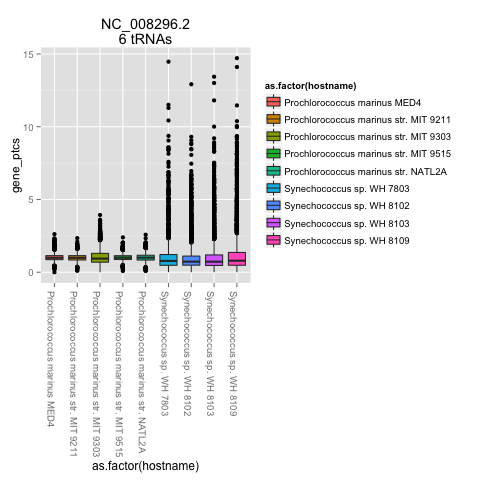

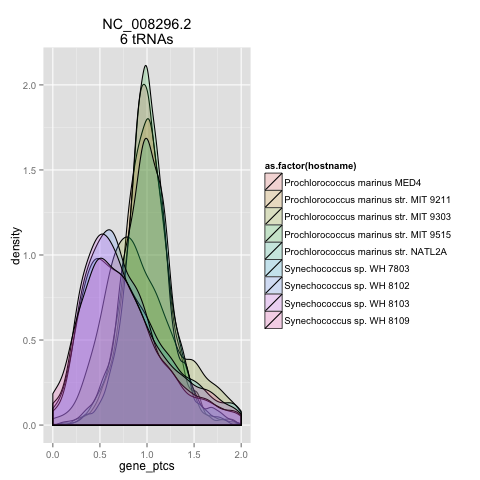

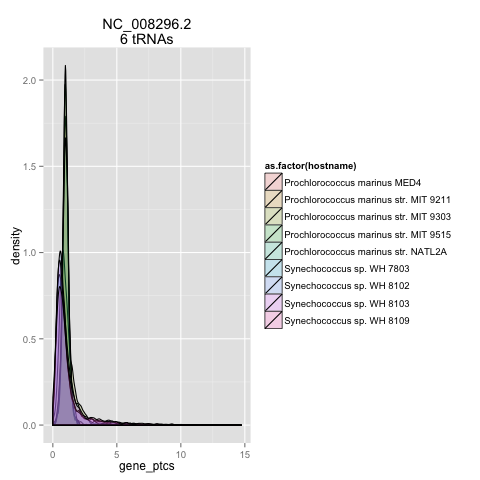

In [28]:
%%R -i syn9_hosts -i accs
#p="NC_015281.1" #S-ShM2
p="NC_008296.2" #syn9

#codonlist<-read.table(paste("./data/pgenomes/opmh/","NC_008296.2",".trna", sep=""), sep="\t", skip=3)%>%.$V6

codonlist<-read.table(paste("./data/pgenomes/opmh/",p,".trna", sep=""), sep="\t", skip=3)%>%.$V6
combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),host=factor())

for (j in syn9_hosts){
    codonm<-format_codon_m(paste("./data/syn9_hosts/",j,".cds.m", sep=""),paste("data/syn9_hosts/",j,".cds.w", sep=""))
    codonw<-read.table(paste("./data/syn9_hosts/",j,".cds.w", sep=""))
    Genome_rep<-Gptr(codonlist, codonm)
    gene_ptcs<-vector()
    for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codons_tested")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(na.omit(Together$pig))
    gene_ptcs<-c(gene_ptcs, ptcs)
}
    host_w<-read.table(paste("./data/syn9_hosts/",j,".cds.w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./data/syn9_hosts/",j,".cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$host<-j
    combo<-rbind(host_w, combo)

}
    combo$hostname<-names$V2[match(combo$host, names$V1)]
    ggplot(na.omit(combo), aes(x=as.factor(hostname), y=gene_ptcs, fill=as.factor(hostname)))+geom_boxplot()->f
    f<-f+theme(axis.text.x=element_text(angle = -90, hjust = 0))
    f<-f+labs(title=paste(p,"\n",length(codonlist)," tRNAs", sep=""))
    plot(f)

    ggplot(na.omit(combo), aes(gene_ptcs, fill=as.factor(hostname)))+geom_density(alpha=0.2)+xlim(c(0,2))->g
    g<-g+labs(title=paste(p,"\n",length(codonlist)," tRNAs", sep=""))
    plot(g)

    ggplot(na.omit(combo), aes(gene_ptcs, fill=as.factor(hostname)))+geom_density(alpha=0.2)->g1
    plot(g1+labs(title=paste(p,"\n",length(codonlist)," tRNAs", sep="")))
    
    for (h in unique(as.factor(combo$hostname))){
    combo%>%filter(hostname==h)->indiv
    outliers<-calout.detect(na.omit(indiv$gene_ptcs), alpha=0.05, method="boxplot")
    print(paste("Syn9",h, nrow(indiv[outliers$ind,c(1,8)]), sep=": "))
    }

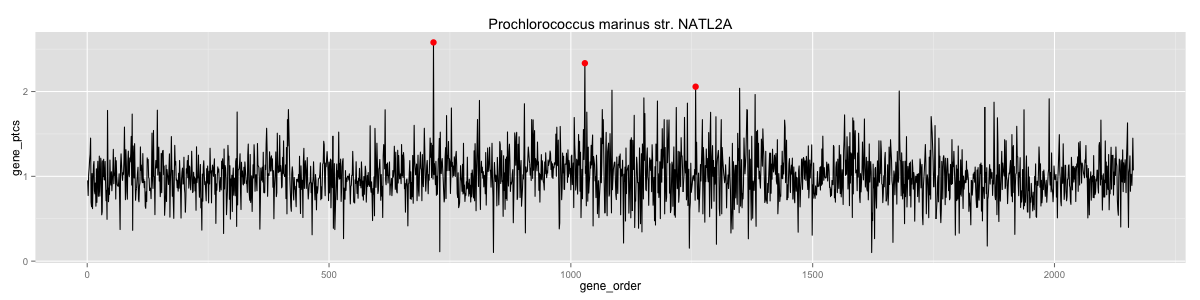

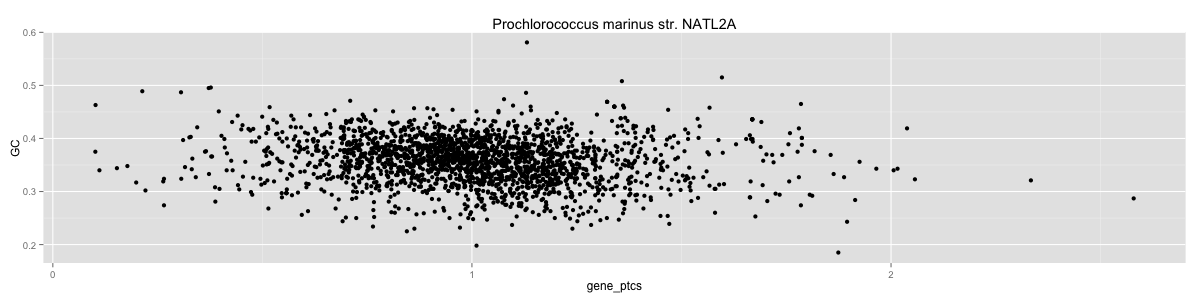

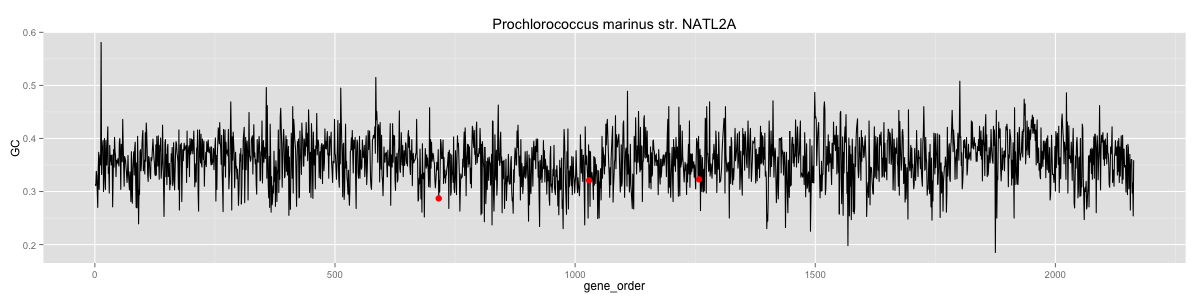

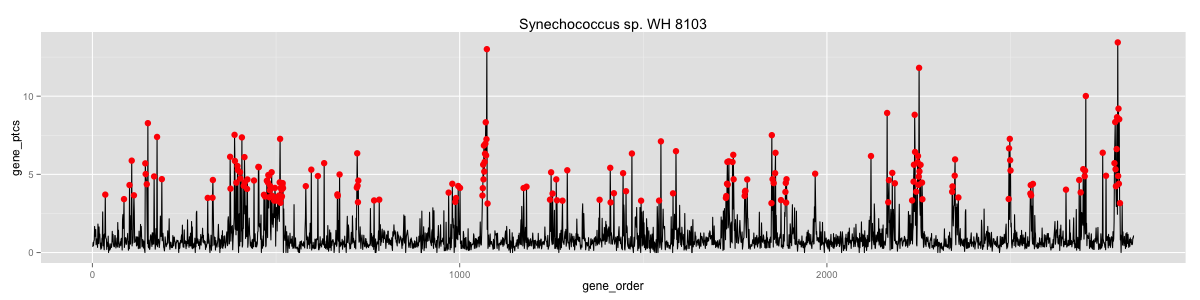

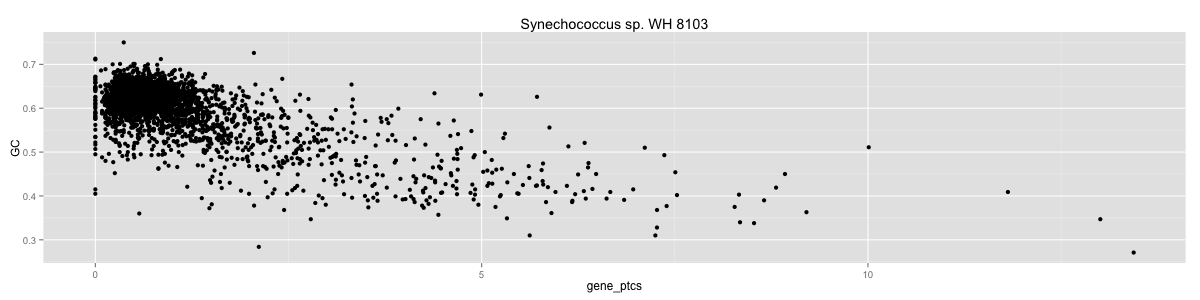

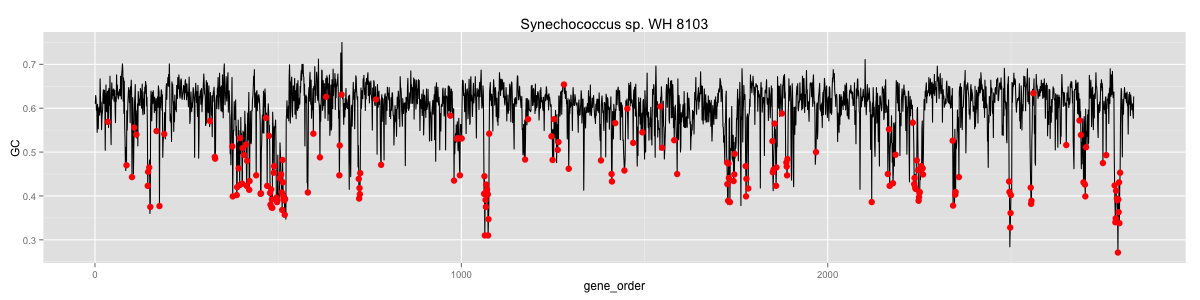

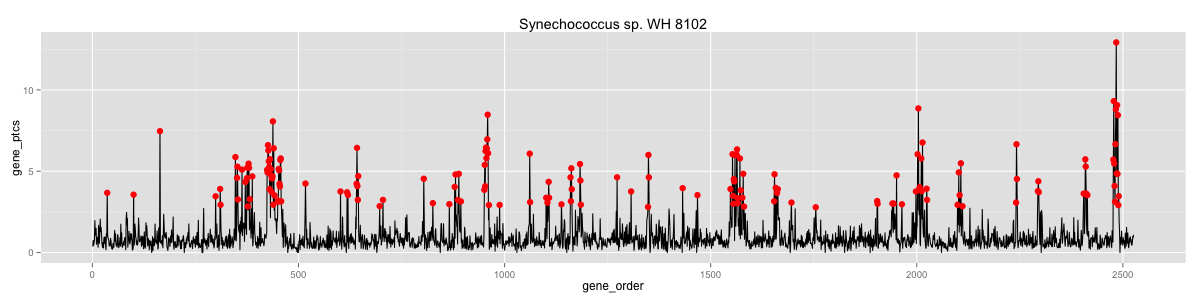

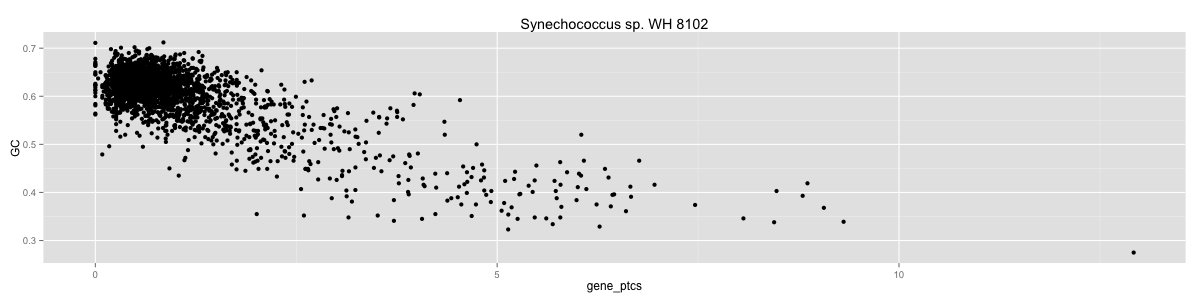

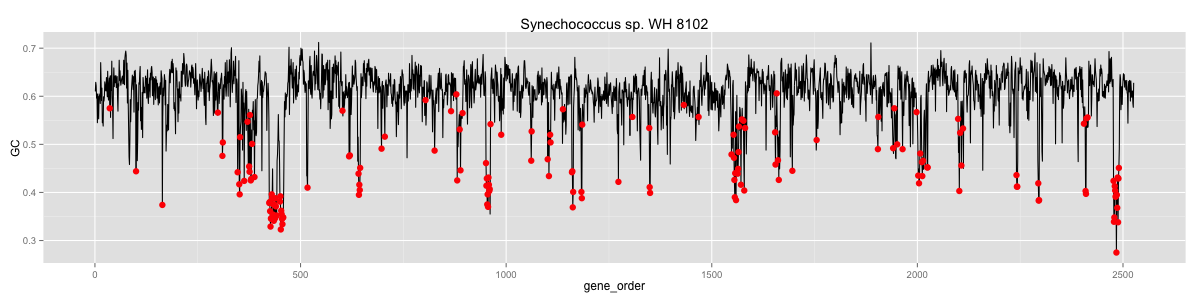

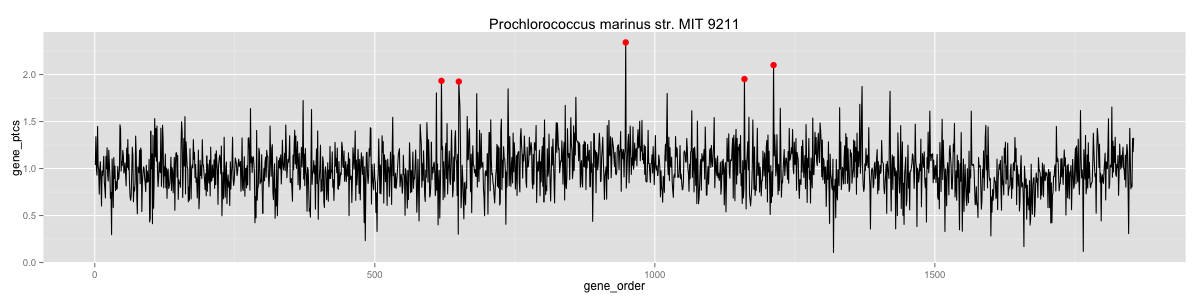

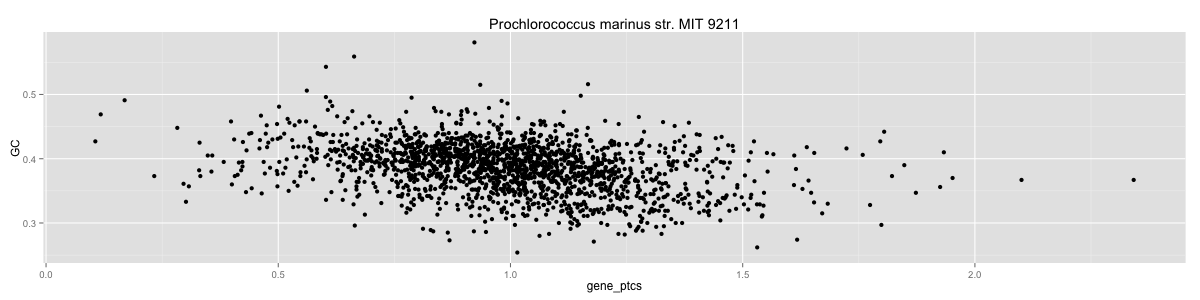

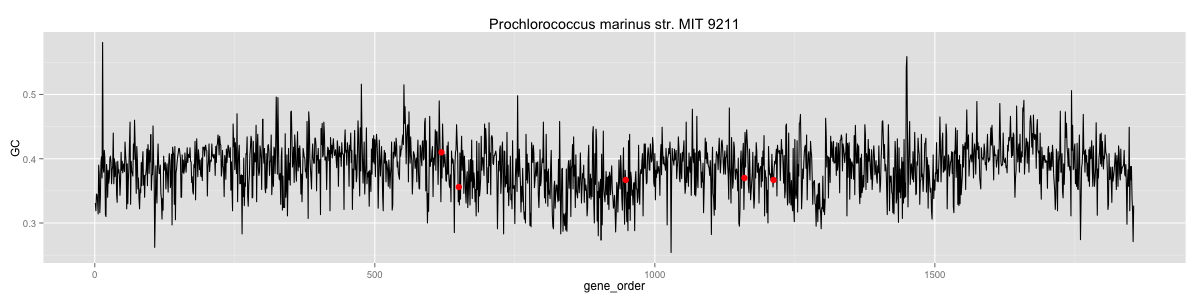

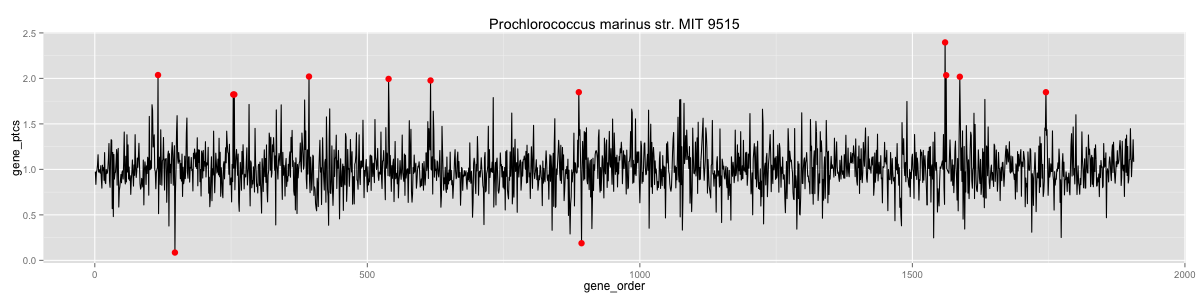

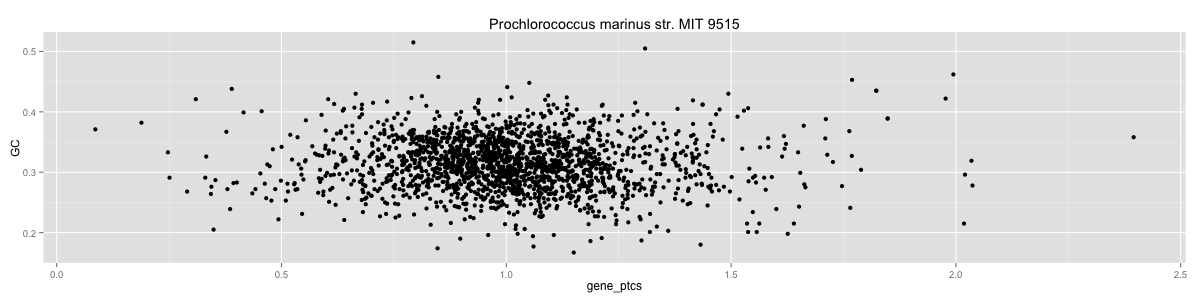

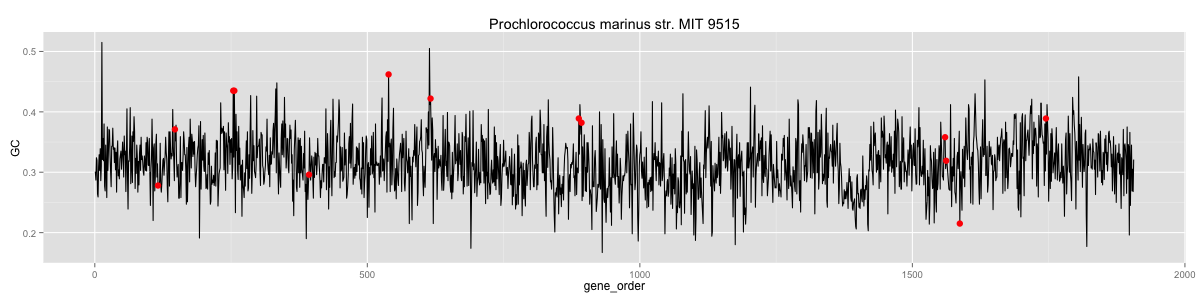

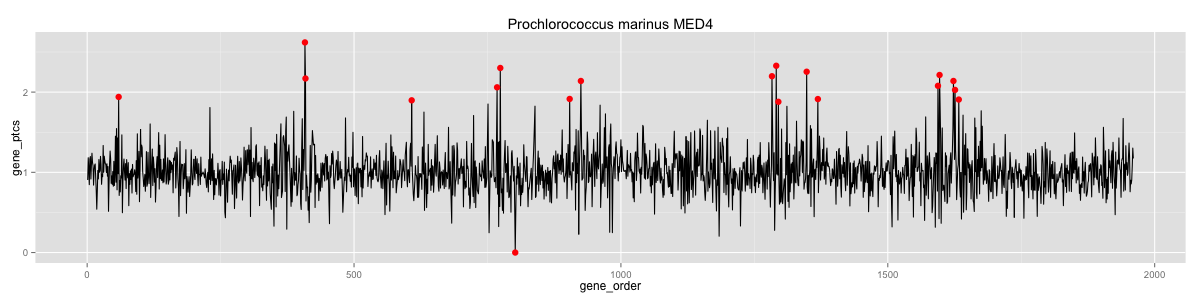

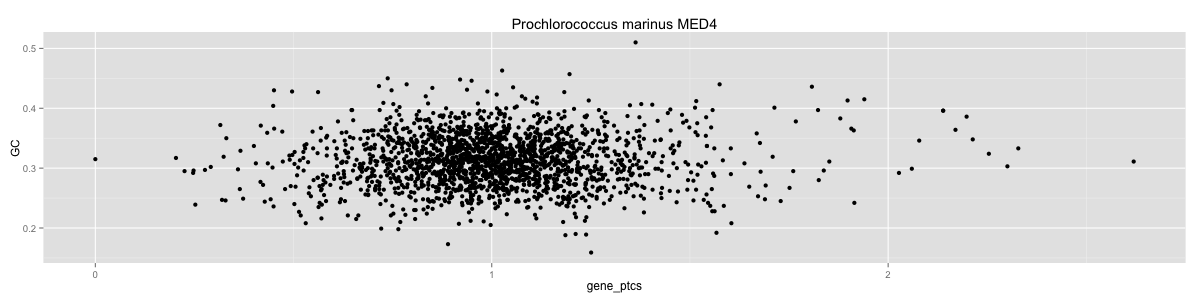

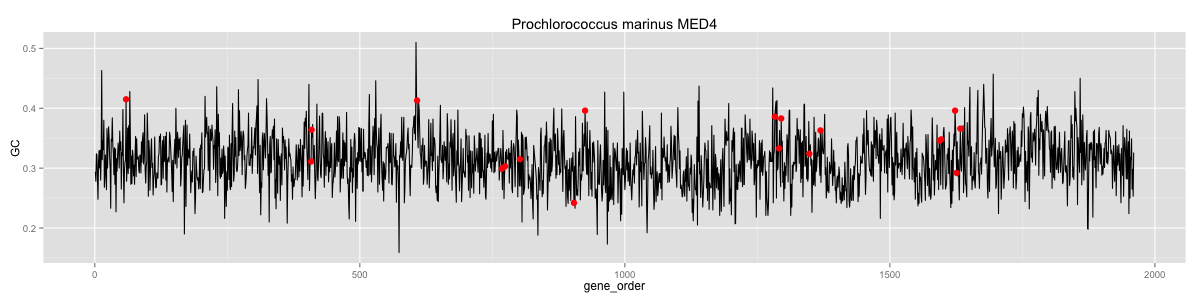

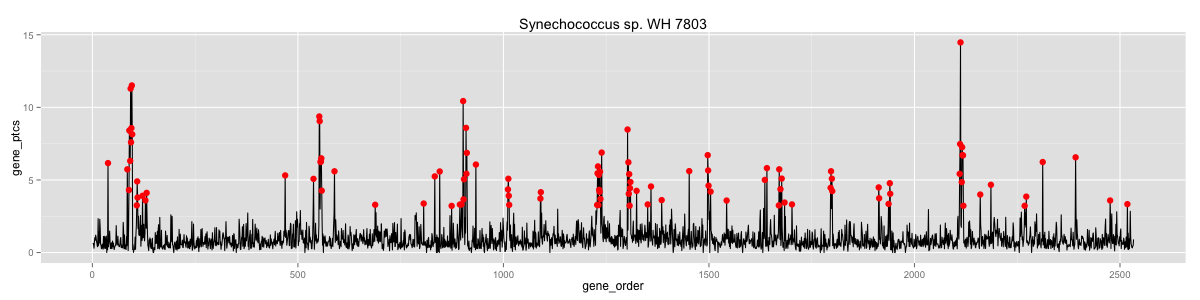

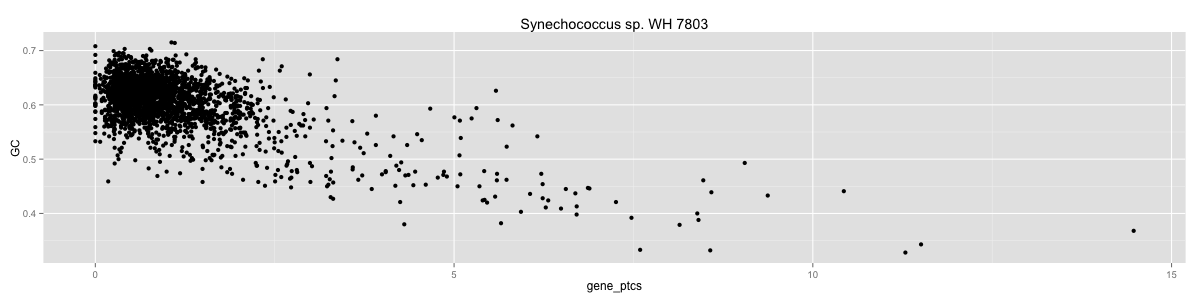

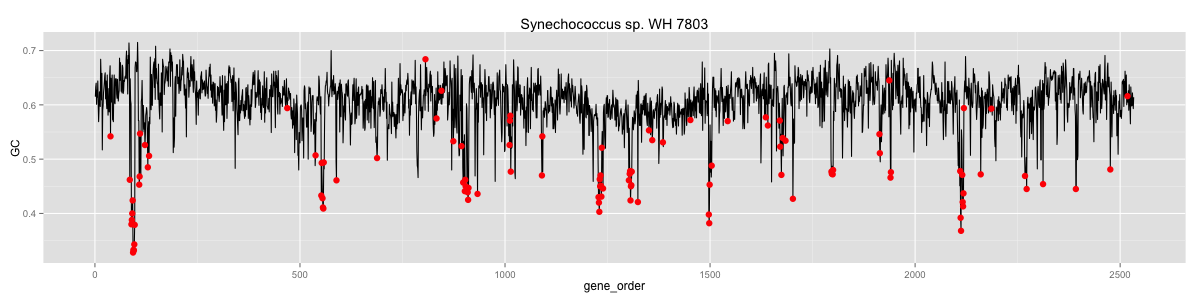

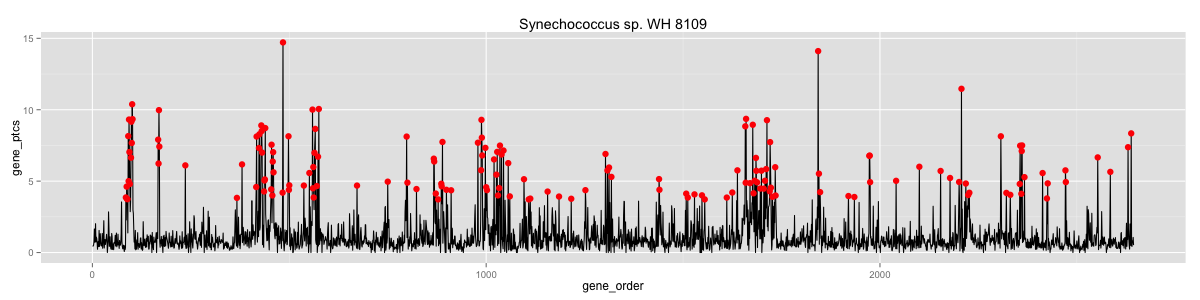

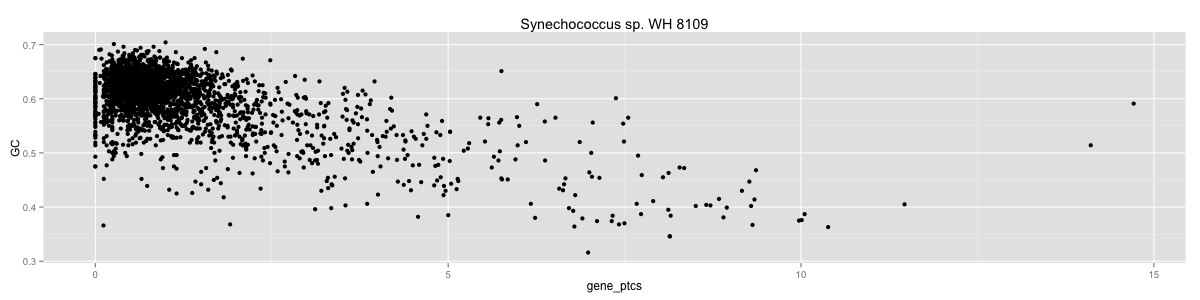

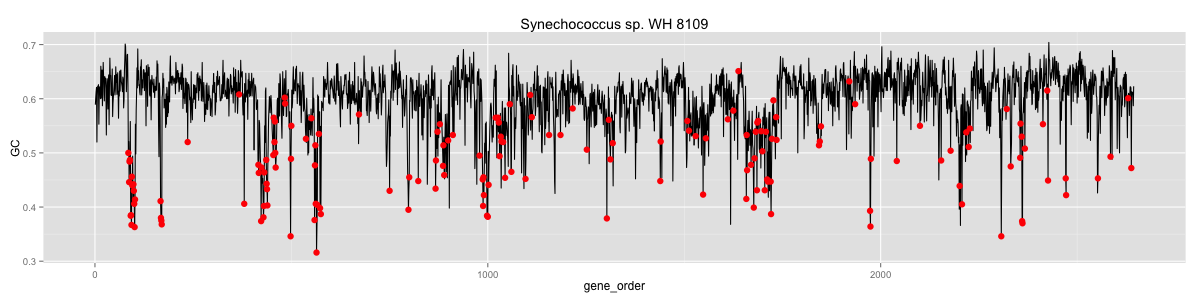

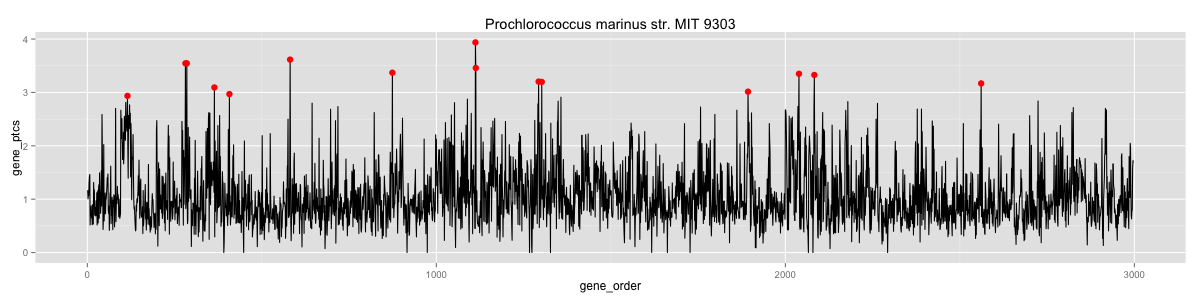

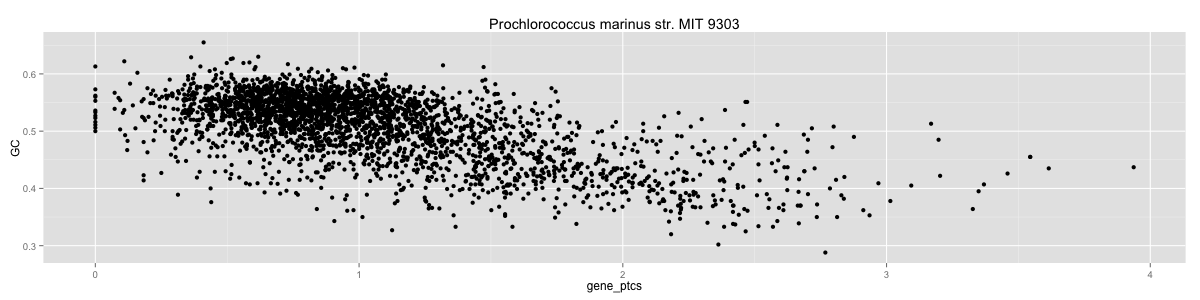

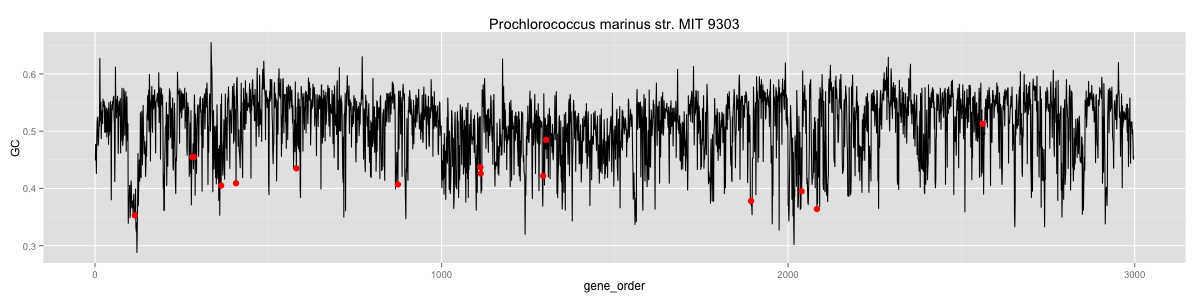

In [30]:
%%R -w 1200 -h 300
for (h in unique(as.factor(combo$hostname))){
    combo%>%filter(hostname==h)%>%na.omit->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    ggplot(NULL, aes(gene_order, gene_ptcs))+geom_line(data=indiv)+labs(title=h)->l
    l+geom_point(data= indiv[outliers$ind,],color="red", cex=3)->o
    plot(o)
    
    ggplot(indiv, aes(gene_ptcs, GC))+geom_point()+labs(title=h)->k
    plot(k)
    location<-max(indiv$GC)+0.01
    j<-ggplot(indiv, aes(gene_order, GC))+geom_line()+
        geom_point(data= indiv[outliers$ind,],color="red", cex=3, aes(x=gene_order, y=GC))+labs(title=h)
    plot(j)
    #    plot(o)
    #print(indiv[outliers$ind,c(2)])
    }

In [42]:
%%R
str(combo[0,])
str(combo)

'data.frame':	0 obs. of  10 variables:
 $ gene_order: int 
 $ title     : chr 
 $ Nc        : num 
 $ GC3s      : num 
 $ GC        : num 
 $ L_aa      : int 
 $ gene_ptcs : num 
 $ product   : Factor w/ 6059 levels "(1->4)-alpha-D-glucan branching enzyme",..: 
 $ host      : chr 
 $ hostname  : chr 
'data.frame':	21419 obs. of  10 variables:
 $ gene_order: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title     : chr  "PMN2A_1328" "PMN2A_1329" "PMN2A_1330" "PMN2A_1331" ...
 $ Nc        : num  36 38.2 36.2 37.5 38.6 ...
 $ GC3s      : num  0.146 0.131 0.123 0.13 0.146 0.122 0.147 0.22 0.154 0.179 ...
 $ GC        : num  0.314 0.311 0.338 0.33 0.299 0.27 0.341 0.374 0.304 0.353 ...
 $ L_aa      : int  386 256 803 485 827 288 312 240 208 431 ...
 $ gene_ptcs : num  0.952 0.774 1.019 1.094 1.197 ...
 $ product   : Factor w/ 6059 levels "(1->4)-alpha-D-glucan branching enzyme",..: 302 927 686 93 315 1031 211 1091 106 971 ...
 $ host      : chr  "CP000095.2" "CP000095.2" "CP000095.2" "CP000095.2" ...
 $

In [26]:
%%R

out_genes<-vector()
out_host<-vector()


for (h in unique(as.factor(combo$hostname))){
    print(h)
    combo%>%filter(hostname==h)->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    indiv[outliers$ind,][which(indiv$gene_ptcs>1),]->io
    print(io[c(1,8)])
    out_genes<-c(out_genes, io$title)
    out_host<-c(out_host, io$host)
    }
outliers<-cbind(out_genes, out_host)
hosts=out_host%>%unique
write.table(outliers, "syn9_host_outliers.txt", quote=FALSE, row.names=FALSE, col.names=FALSE, sep="\t")

In [92]:
from pyfaidx import Fasta

genes=open("syn9_host_outliers.txt").readlines()
out=open("syn9_host_outliers.fasta","w")

for h in syn9_hosts:
    f=Fasta("./data/syn9_hosts/"+h+".cds.fasta")
    for line in genes:
        if line.split("\t")[1].replace("\n","").replace(" ","")==h:
            gene_name=line.split("\t")[0]
            sequence=str(f[gene_name])
            out.write(">"+gene_name+"\n"+sequence+"\n")
out.close()
!open syn9_host_outliers.fasta -a textedit

In [93]:
!scp syn9_host_outliers.fasta jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/syn9/

syn9_host_outliers.fasta                      100%  146KB 146.0KB/s   00:00    


In [94]:
!scp ./scripts/outlier_blast.slurm jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/syn9/

outlier_blast.slurm                           100%  988     1.0KB/s   00:00    


In [31]:
%%R
host_blast<-read.table("./data/syn9_hosts/syn9_hosts_cds_recip_blastn.txt", header=FALSE, sep="\t")
#remove self-matches
host_blast%>%nrow%>%print
host_blast$hit_hostname<-combo$hostname[match(host_blast$V2, combo$title)]
host_blast$hostname<-combo$hostname[match(host_blast$V1, combo$title)]
host_blast[which(host_blast$hostname!=host_blast$hit_hostname),]->host_blast
host_blast%>%nrow%>%print
aggregate(V12~V1, data=host_blast, max)%>%merge(host_blast, all.x=T)%>%.[,c(1,3,4,13)]->top_score
colnames(top_score)[c(1,2,3)]<-c("title","closest_hit","pct_id")
top_score%>%nrow%>%print
combo1<-merge(combo, top_score, by="title", all.x=TRUE)
head(combo1)

[1] 41077
[1] 14997
[1] 9586
                      title gene_order    Nc  GC3s    GC L_aa gene_ptcs
1                      cpeR       2239 48.58 0.298 0.419  101 8.8100359
2                      cpeS       2237 49.60 0.370 0.441  180 5.6173172
3 drug/metabolite_transport       1236 43.73 0.749 0.662  278 1.0619629
4               P9211_00001          1 39.98 0.155 0.331  397 1.0371330
5               P9211_00011          2 37.71 0.146 0.319  255 1.3388083
6               P9211_00021          3 36.08 0.121 0.345  804 0.9878859
                                            product       host
1                    phycoerythrin operon regulator LN847356.1
2 phycoerythrobilin:Cys-82 beta-phycoerythrin lyase LN847356.1
3                                              <NA> LN847356.1
4                    DNA polymerase III, beta chain CP000878.1
5                    conserved hypothetical protein CP000878.1
6   phosphoribosylformylglycinamidine synthetase II CP000878.1
                          

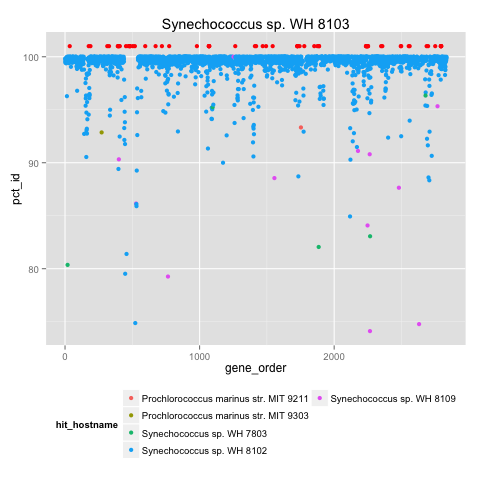

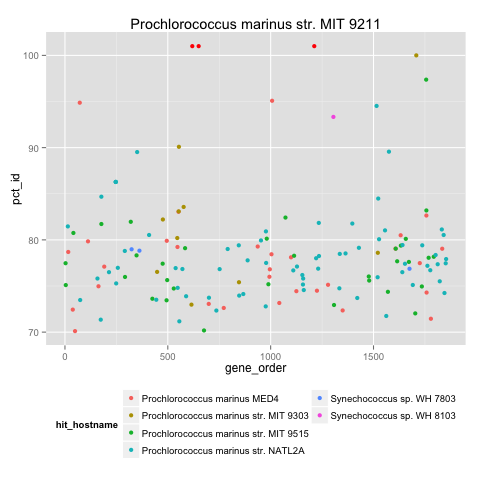

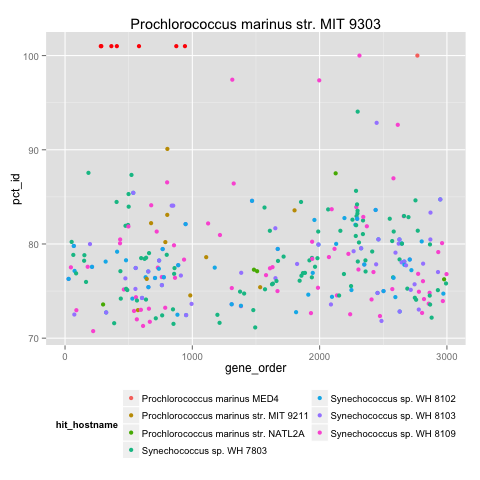

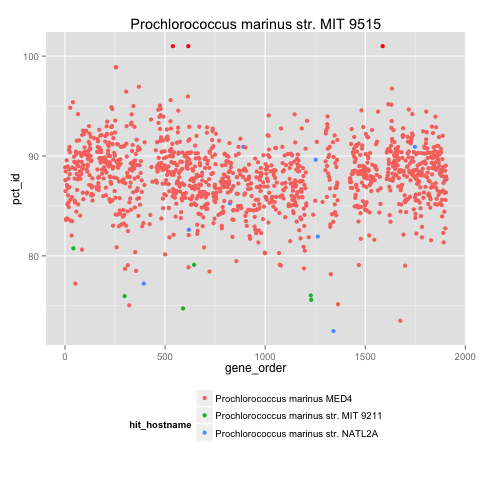

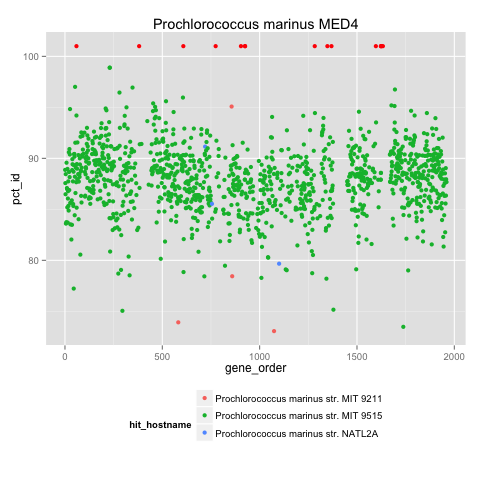

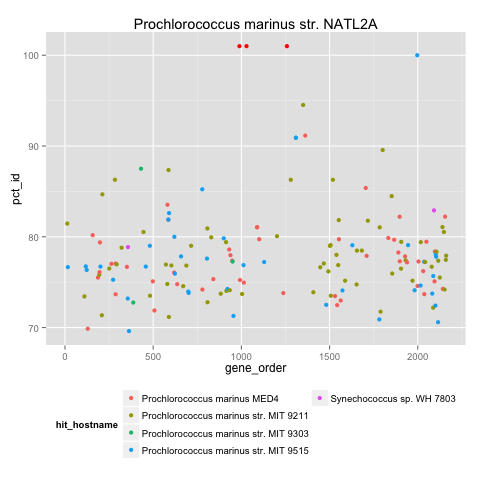

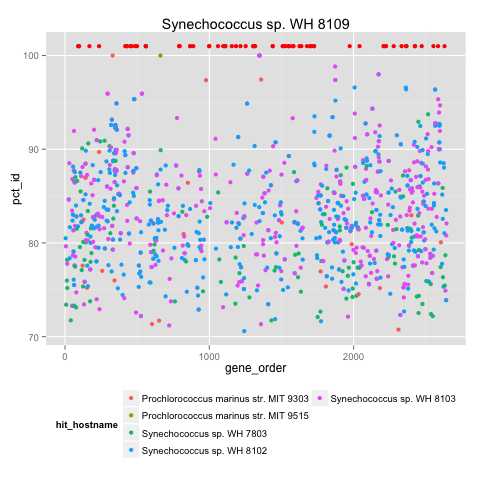

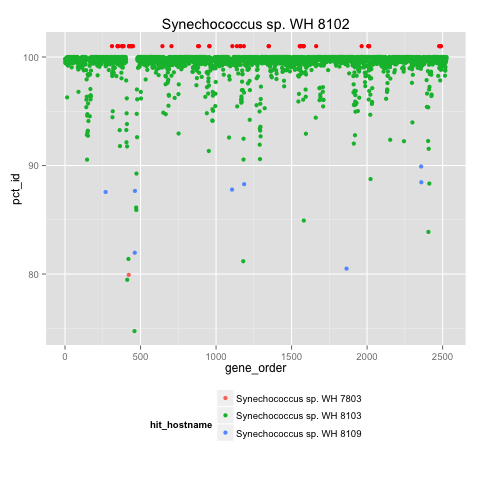

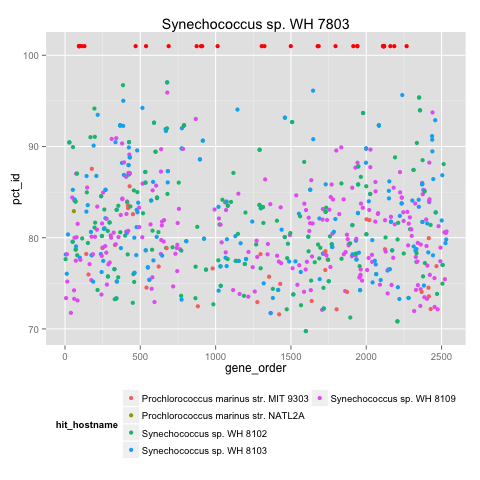

In [32]:
%%R
for (h in unique(as.factor(combo1$hostname))){
    #combo1%>%filter(hostname==h)%>%na.omit->indiv
    combo1%>%filter(hostname==h)->indiv
    outliers<-calout.detect(na.omit(indiv$gene_ptcs), alpha=0.05, method="boxplot")
    indiv%>%ggplot(aes(gene_order, pct_id, col=hit_hostname))->fig
    fig+geom_point()+theme(legend.position="bottom")+guides(col = guide_legend(nrow = 4))->fig
    fig+scale_shape_manual(values = c(0, 5, 6, 15))->fig
    fig+geom_point(data= indiv[outliers$ind,][indiv$gene_ptcs>1,],color="red", aes(gene_order, 101))+labs(title=h)->o
    #o+geom_line(data=indiv, color="purple", linetype=2, aes(gene_order, GC*100))->o
    plot(o)
    }

In [108]:
path="./data/syn9_hosts/"
p="NC_008296.2"

gbk="./data/pgenomes/"+p+".gbk"
gbk_to_fasta(gbk, path+p+".fasta")
run_trna_scan(path+p+".fasta", path+p+".trna")
gbk_to_cds_fasta(gbk, path+p+".cds.fasta")
run_codonW(path+p+".cds.fasta",path+p+".cds.w")
run_codonM(path+p+".cds.fasta", path+p+".cds.m")
extract_cds_annotations(gbk, path+p+".cds.annotations.txt")

tRNA scan of ./data/syn9_hosts/NC_008296.2.fasta is done!
226 CDS sequences extracted from ./data/pgenomes/NC_008296.2.gbk
226 annotated features in ./data/pgenomes/NC_008296.2.gbk


In [33]:
%%R -i syn9_hosts

hosts<-syn9_hosts

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),genome=factor(),host=factor())

prefix="./data/syn9_hosts/"

p="NC_008296.2" #syn9
codonlist<-read.table(paste(prefix,p,".trna",sep=""), skip=3, header=FALSE,sep="\t")
codonlist$V6%>%unique->codonlist

for (n in seq(1,length(hosts))){

h=hosts[n]
hcodonm<-format_codon_m(paste(prefix,h,".cds.m", sep=""),paste(prefix,h,".cds.w", sep=""))
    
for (j in c(p, h)){
    codonm<-format_codon_m(paste(prefix,j,".cds.m", sep=""),paste(prefix,j,".cds.w", sep=""))
    #codonw<-read.table(paste(prefix,j,".cds.w", sep=""))
    Genome_rep<-Gptr(codonlist, hcodonm)
    gene_ptcs<-vector()
    for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codons_tested")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(na.omit(Together$pig))
    gene_ptcs<-c(gene_ptcs, ptcs)
}
    host_w<-read.table(paste(prefix,j,".cds.w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste(prefix,j,".cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$genome<-paste(j)
    host_w$host<-paste(h)
    combo<-rbind(host_w, combo)
}}

Read 182817 items
Read 13786 items
Read 182817 items
Read 161284 items
Read 13786 items
Read 161284 items
Read 154513 items
Read 13786 items
Read 154513 items
Read 119560 items
Read 13786 items
Read 119560 items
Read 116266 items
Read 13786 items
Read 116266 items
Read 113155 items
Read 13786 items
Read 113155 items
Read 154086 items
Read 13786 items
Read 154086 items
Read 172935 items
Read 13786 items
Read 172935 items
Read 131943 items
Read 13786 items
Read 131943 items


In [34]:
%%R
combo$hostname<-names$V2[match(combo$host, names$V1)]
head(combo)

  gene_order      title    Nc  GC3s    GC L_aa gene_ptcs
1          1 PMN2A_1328 36.04 0.146 0.314  386 0.9522298
2          2 PMN2A_1329 38.16 0.131 0.311  256 0.7735906
3          3 PMN2A_1330 36.23 0.123 0.338  803 1.0193673
4          4 PMN2A_1331 37.51 0.130 0.330  485 1.0937373
5          5 PMN2A_1332 38.60 0.146 0.299  827 1.1966050
6          6 PMN2A_1333 37.86 0.122 0.270  288 1.2594439
                                                product     genome       host
1                      DNA polymerase III, beta subunit CP000095.2 CP000095.2
2                        RNA metabolism-related protein CP000095.2 CP000095.2
3 phosphoribosylformylglycinamidine synthase subunit II CP000095.2 CP000095.2
4                        amidophosphoribosyltransferase CP000095.2 CP000095.2
5                        DNA topoisomerase IV subunit A CP000095.2 CP000095.2
6                                            TPR repeat CP000095.2 CP000095.2
                             hostname
1 Prochlorococcus

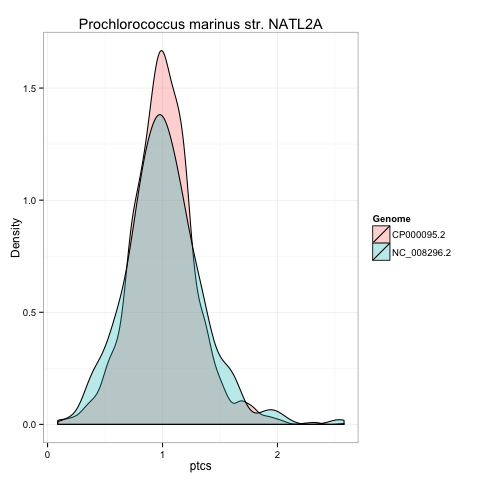

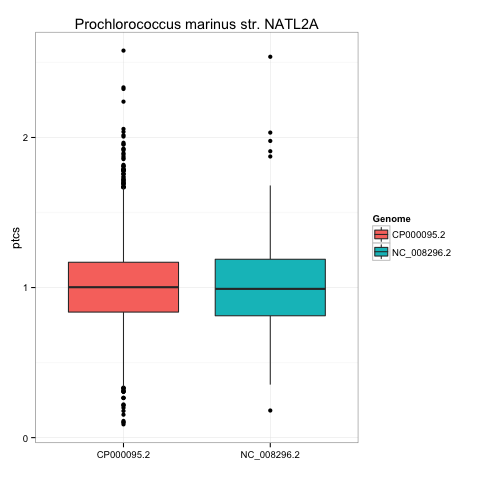

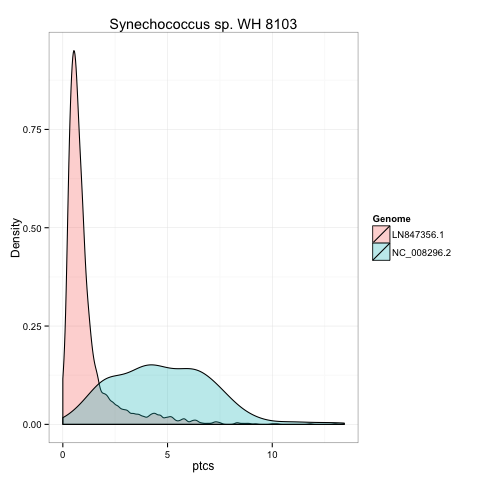

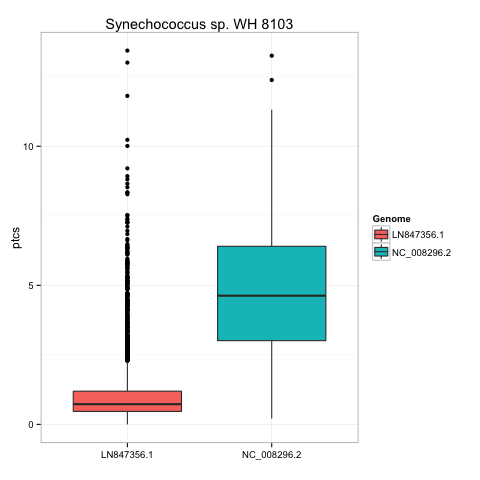

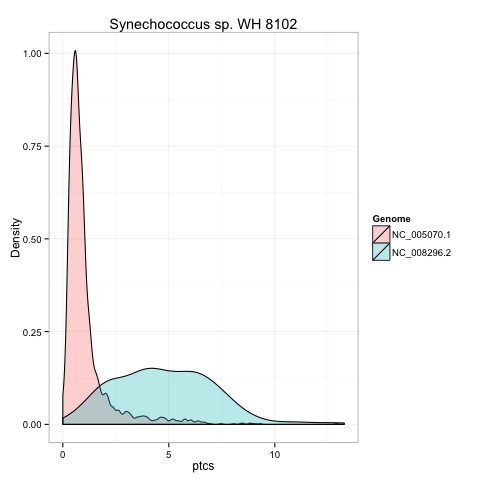

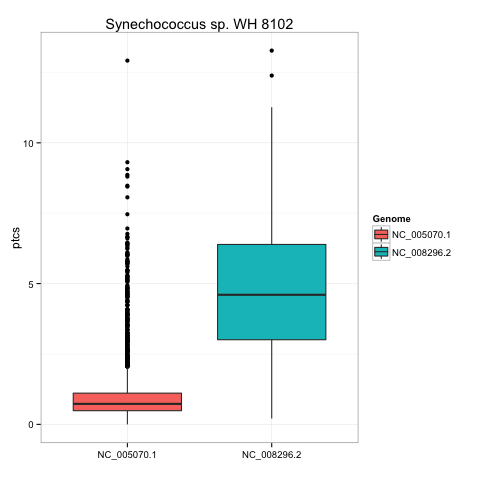

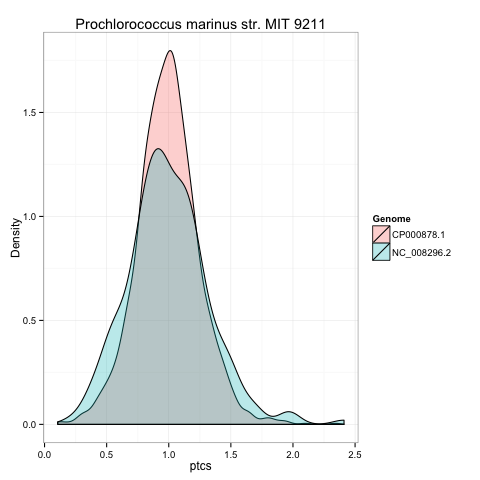

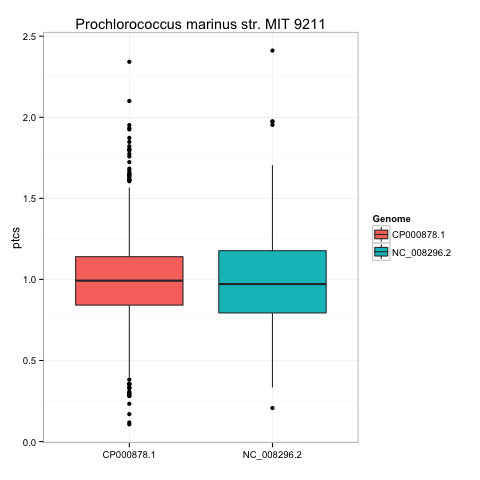

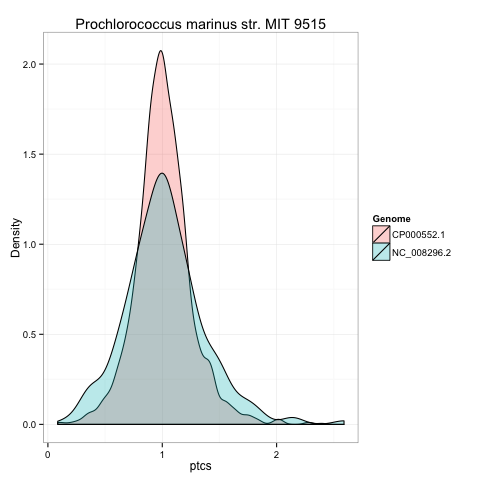

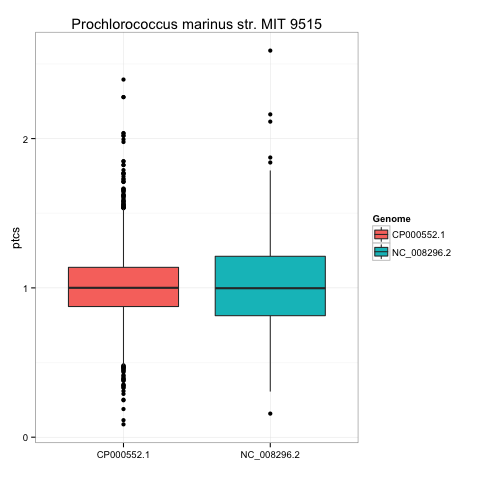

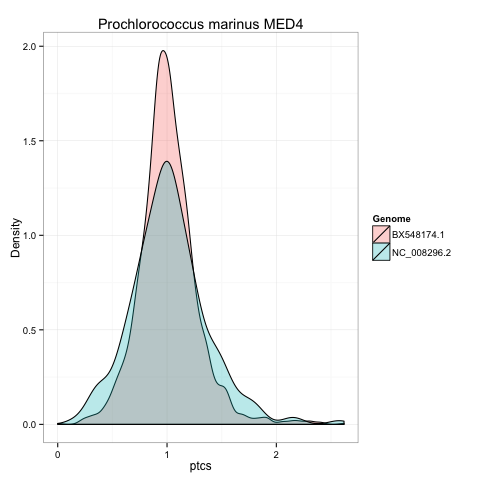

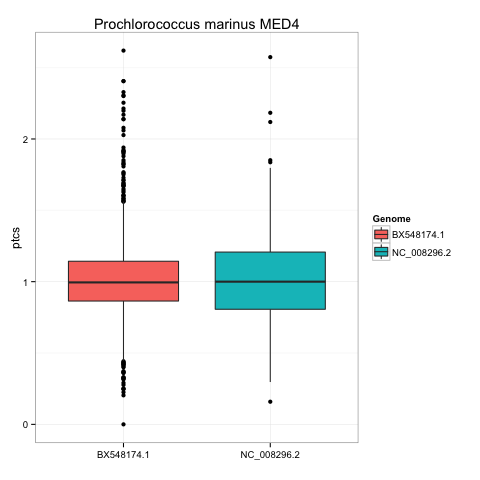

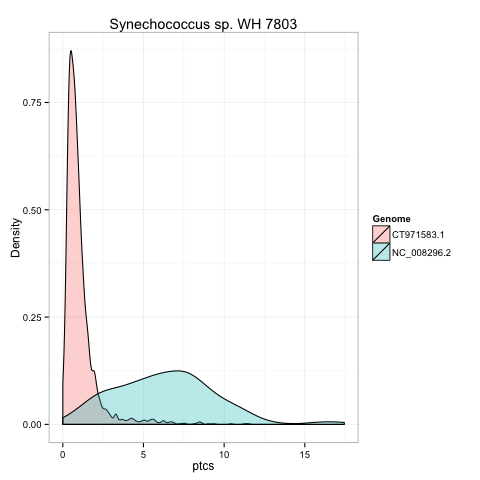

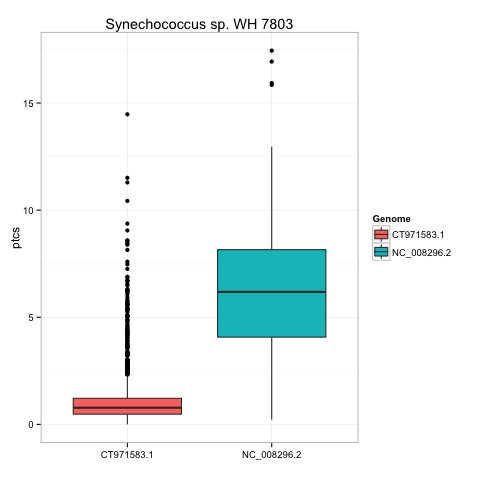

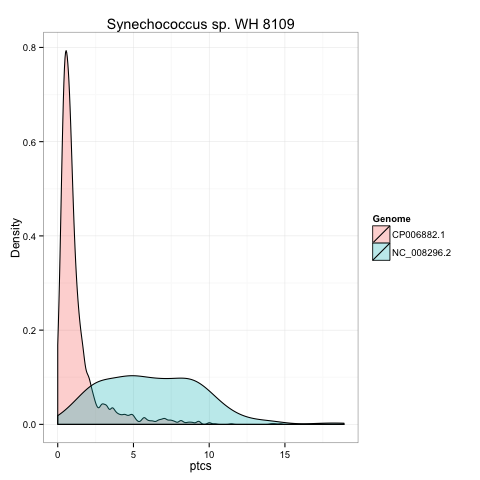

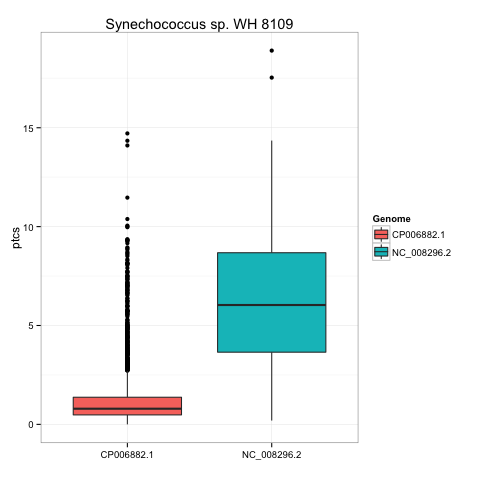

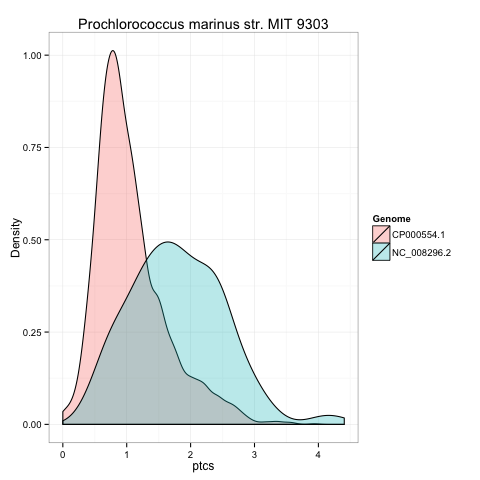

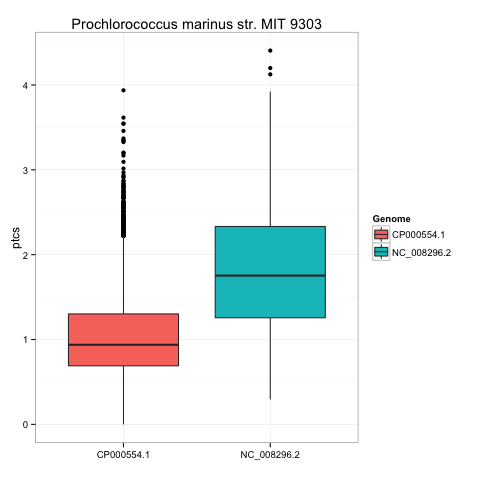

In [36]:
%%R
plots<-list()

for (h in combo$hostname%>%unique){
    indiv<-combo%>%filter(hostname==h)

    ggplot(indiv, aes(gene_ptcs, fill=as.factor(genome)))+geom_density(alpha=0.3)->g
    g<-g+labs(title=h, x="ptcs",y="Density", fill="Genome")+theme_bw()
    

    ggplot(indiv, aes(as.factor(genome), gene_ptcs, fill=as.factor(genome)))+geom_boxplot()->l
    l<-l+labs(title=h, x="", y="ptcs", fill="Genome")+theme_bw()
    plot(g)
    plot(l)
    
    #plots[[i]] <- p1 
    plots[[paste(h, 1, sep="")]]<-g
    plots[[paste(h, 2, sep="")]]<-l
    }



In [131]:
%%R
png("multiple_ptcs_one_phage.png")
multiplot(plotlist = plots, cols = 2)
dev.off()